In [58]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from models.batchLoader import BatchLoader
from models.unetResidual import UnetResidual
from models.unet import Unet

In [67]:
model_file_name = 'unet-residual-dice.h5'
#model_file_name = 'unet-baseline.h5'
model_name = 'foo'
image_size = (256, 256)
batch_size = 10
image_folder = 's2cloudless_imagery'
#image_folder = 'nwpu_images'
mask_folder = 's2cloudless_label_imagery'
#mask_folder = 'nwpu_label_images'
model = UnetResidual(model_name, image_size, version=1)
#model = Unet(model_name, image_size, version=1)
model.restore(model_file_name)
images = glob.glob(os.path.join(image_folder, 'data', '*.jpg'))

In [60]:
def pair_image_with_mask(image, mask):
    mask = mask.squeeze()
    mask = np.stack((mask,) * 3, axis=-1)
    return np.concatenate([image, mask], axis = 1)

def display_predictions(X, Y, batch_size):
    columns_count = 2
    figure_size = (8, 10)
    rows = batch_size // columns_count
    _, axs = plt.subplots(rows, columns_count, figsize = figure_size)
    axs = axs.flatten()
    for i in range (0, batch_size):
        combined = pair_image_with_mask(X[i], Y[i])
        axs[i].axis('off')
        axs[i].imshow(combined)
    plt.tight_layout()

Display a list of the layers in the model.

In [61]:
model.get_model_summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_321 (Conv2D)             (None, 256, 256, 16) 448         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_224 (BatchN (None, 256, 256, 16) 64          conv2d_321[0][0]                 
__________________________________________________________________________________________________
conv2d_323 (Conv2D)             (None, 256, 256, 16) 64          input_12[0][0]                   
______________________________________________________________________________________

Create a batch loader to evaluate the model.

In [68]:
batch_loader = BatchLoader(images, image_folder, mask_folder, batch_size, image_size)
batch_generator = batch_loader()

In [83]:
X_test, Y_test = next(batch_generator)

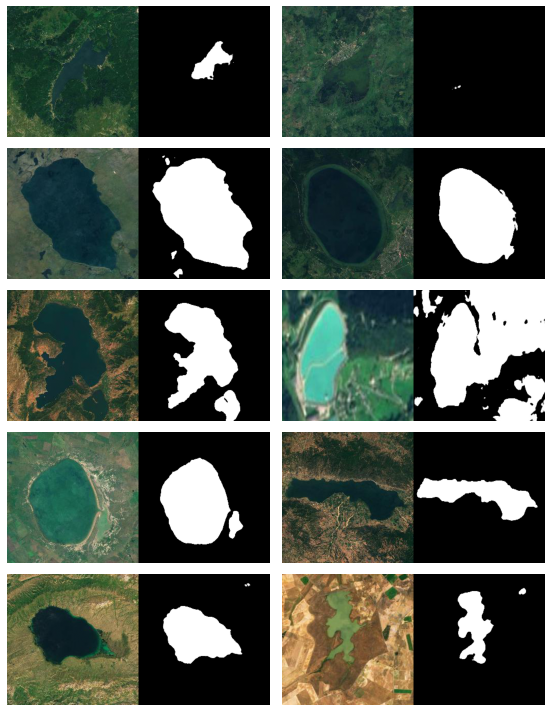

In [84]:
Y_pred = model.predict(X_test)
display_predictions(X_test, Y_pred, batch_size)